# **Install Dependencies**

In [25]:
!pip install langgraph python-dotenv notebook langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.9 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


# **1. Simple Graph**

In [11]:
from typing import TypedDict

class PortfolioState(TypedDict):
    amount_usd: float
    total_usd: float
    total_inr: float

In [12]:
def calc_total(state: PortfolioState) -> PortfolioState:
    state['total_usd'] = state['amount_usd'] * 1.08
    return state

def convert_to_inr(state: PortfolioState) -> PortfolioState:
    state['total_inr'] = state['total_usd'] * 85
    return state

In [13]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(PortfolioState)

builder.add_node("calc_total_node", calc_total)
builder.add_node("convert_to_inr_node", convert_to_inr)

builder.add_edge(START, "calc_total_node")
builder.add_edge("calc_total_node", "convert_to_inr_node")
builder.add_edge("convert_to_inr_node", END)

graph = builder.compile()

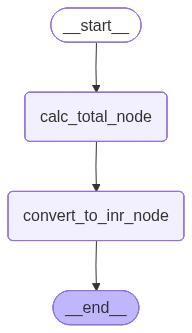

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
graph.invoke({"amount_usd": 100000})

{'amount_usd': 100000, 'total_usd': 108000.0, 'total_inr': 9180000.0}

# **2. Graph with Condition**

In [16]:
from typing import TypedDict, Literal

class PortfolioState(TypedDict):
    amount_usd: float
    total_usd: float
    target_currency: Literal["INR", "EUR"]
    total: float

In [17]:
def calc_total(state: PortfolioState) -> PortfolioState:
    state['total_usd'] = state['amount_usd'] * 1.08
    return state

def convert_to_inr(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 85
    return state

def convert_to_eur(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 0.9
    return state

def choose_conversion(state: PortfolioState) -> str:
    return state["target_currency"]

In [18]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(PortfolioState)

builder.add_node("calc_total_node", calc_total)
builder.add_node("convert_to_inr_node", convert_to_inr)
builder.add_node("convert_to_eur_node", convert_to_eur)

builder.add_edge(START, "calc_total_node")
builder.add_conditional_edges(
    "calc_total_node",
    choose_conversion,
    {
        "INR": "convert_to_inr_node",
        "EUR": "convert_to_eur_node",
    }
)
builder.add_edge(["convert_to_inr_node", "convert_to_eur_node"], END)

graph = builder.compile()

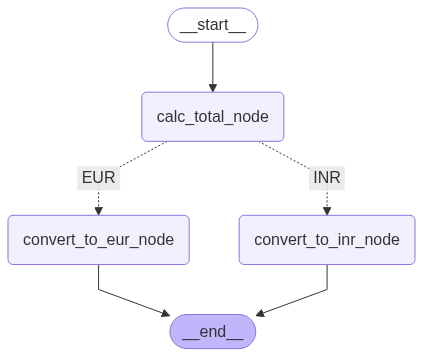

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
graph.invoke({"amount_usd": 1000, "target_currency": "EUR"})

{'amount_usd': 1000,
 'total_usd': 1080.0,
 'target_currency': 'EUR',
 'total': 972.0}

# **3. ChatBot**

In [10]:
from typing import Annotated
from dotenv import load_dotenv
load_dotenv()

from typing_extensions import TypedDict
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [11]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

In [14]:
llm = init_chat_model("google_genai:gemini-2.0-flash", google_api_key=GOOGLE_API_KEY)

class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State) -> State:
    return {"messages": [llm.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("chatbot_node", chatbot)

builder.add_edge(START, "chatbot_node")
builder.add_edge("chatbot_node", END)

graph = builder.compile()

In [15]:
message = {"role": "user", "content": "Who walked on the moon for the first time? Print only the name"}
# message = {"role": "user", "content": "What is the latest price of MSFT stock?"}
response = graph.invoke({"messages":[message]})

response["messages"]

[HumanMessage(content='Who walked on the moon for the first time? Print only the name', additional_kwargs={}, response_metadata={}, id='a3523259-608d-4b2d-9480-4c694613670b'),
 AIMessage(content='Neil Armstrong', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--23546f45-ec28-4e62-9641-14cee64c3092-0', usage_metadata={'input_tokens': 14, 'output_tokens': 3, 'total_tokens': 17, 'input_token_details': {'cache_read': 0}})]

In [16]:
state = None
while True:
    in_message = input("You: ")
    if in_message.lower() in {"quit","exit"}:
        break
    if state is None:
        state: State = {
            "messages": [{"role": "user", "content": in_message}]
        }
    else:
        state["messages"].append({"role": "user", "content": in_message})

    state = graph.invoke(state)
    print("Bot:", state["messages"][-1].content)

You: Who Invented AI?
Bot: The invention of AI is a complex question without a single, definitive answer. It's more accurate to say that AI emerged from the contributions of many individuals across various fields. Here's a breakdown:

*   **Alan Turing:** Often considered a foundational figure, Turing's work on computability and his "Turing Test" (proposed in 1950) were crucial in shaping the concept of machine intelligence. He explored the idea of machines thinking and learning.
*   **The Dartmouth Workshop (1956):** This event, organized by **John McCarthy**, is widely considered the birthplace of AI as a formal field. McCarthy coined the term "Artificial Intelligence." Other key attendees included **Marvin Minsky, Nathaniel Rochester, and Claude Shannon**.
*   **John McCarthy:** As mentioned above, McCarthy not only coined the term "Artificial Intelligence" but also developed Lisp, an early and influential programming language for AI research. He also contributed to early AI concept

# **4. Tool Call**

In [17]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [18]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

In [19]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [20]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash", google_api_key=GOOGLE_API_KEY)
llm_with_tools = llm.bind_tools(tools)

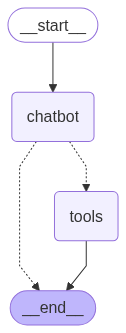

In [21]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)

graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
state = graph.invoke({"messages": [{"role": "user", "content": "What is the price of AAPL stock right now?"}]})
print(state["messages"][-1].content)

100.4


In [23]:
state = graph.invoke({"messages": [{"role": "user", "content": "Who invented theory of relativity? print person name only"}]})
print(state["messages"][-1].content)

Albert Einstein


In [24]:
msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]})
print(state["messages"][-1].content)

200.3


# **5. Tool Call Agent**

In [25]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [26]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

In [27]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [28]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash", google_api_key=GOOGLE_API_KEY)
llm_with_tools = llm.bind_tools(tools)

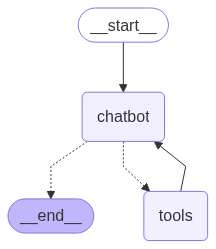

In [29]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
state = graph.invoke({"messages": [{"role": "user", "content": "What is the price of AAPL stock right now?"}]})
print(state["messages"][-1].content)

The current price of AAPL stock is $100.4.


In [31]:
state = graph.invoke({"messages": [{"role": "user", "content": "Who invented theory of relativity? print person name only"}]})
print(state["messages"][-1].content)

Albert Einstein


In [32]:
msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]})
print(state["messages"][-1].content)

The current price for AMZN is $150 and for MSFT is $200.3.
The total cost for 20 AMZN stocks is 20 * $150 = $3000.
The total cost for 15 MSFT stocks is 15 * $200.3 = $3004.5.
The grand total is $3000 + $3004.5 = $6004.5.


# **6. Memory**

In [33]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [34]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

In [35]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [36]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [37]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash", google_api_key=GOOGLE_API_KEY)
llm_with_tools = llm.bind_tools(tools)

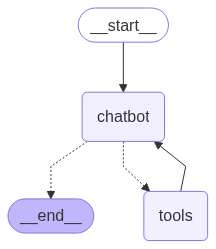

In [38]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
config1 = { 'configurable': { 'thread_id': '1'} }

msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
print(state["messages"][-1].content)

The current price for AMZN is $150 and for MSFT is $200.3.
The total cost for 20 AMZN stocks is 20 * $150 = $3000.
The total cost for 15 MSFT stocks is 15 * $200.3 = $3004.5.
The grand total cost is $3000 + $3004.5 = $6004.5.


In [40]:
config2 = { 'configurable': { 'thread_id': '2'} }

msg = "Tell me the current price of 5 AAPL stocks."

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config2)
print(state["messages"][-1].content)

The current price of one AAPL stock is 100.4. Therefore, the current price of 5 AAPL stocks is 502.0.


In [41]:
msg = "Using the current price tell me the total price of 10 RIL stocks and add it to previous total cost"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
print(state["messages"][-1].content)

The current price of RIL is $87.6. The cost of 10 RIL stocks is 10 * $87.6 = $876.
Adding this to the previous total cost of $6004.5, the new total cost is $6004.5 + $876 = $6880.5.


In [42]:
msg = "Tell me the current price of 5 MSFT stocks and add it to previous total"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config2)
print(state["messages"][-1].content)

The current price of one MSFT stock is 200.3. Therefore, the current price of 5 MSFT stocks is 1001.5. Adding that to the previous total of 502.0, the new total is 1503.5.


# **7. HITL (Human in the Loop)**

In [44]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command


class State(TypedDict):
    messages: Annotated[list, add_messages]

@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol'''
    return {"MSFT": 200.3, "AAPL": 100.4, "AMZN": 150.0, "RIL": 87.6}.get(symbol, 0.0)

@tool
def buy_stocks(symbol: str, quantity: int, total_price: float) -> str:
    '''Buy stocks given the stock symbol and quantity'''
    decision = interrupt(f"Approve buying {quantity} {symbol} stocks for ${total_price:.2f}?")

    if decision == "yes":
        return f"You bought {quantity} shares of {symbol} for a total price of {total_price}"
    else:
        return "Buying declined."


tools = [get_stock_price, buy_stocks]

llm = init_chat_model("google_genai:gemini-2.0-flash", google_api_key=GOOGLE_API_KEY)
llm_with_tools = llm.bind_tools(tools)

def chatbot_node(state: State):
    msg = llm_with_tools.invoke(state["messages"])
    return {"messages": [msg]}

memory = MemorySaver()
builder = StateGraph(State)
builder.add_node("chatbot", chatbot_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
builder.add_edge("chatbot", END)
graph = builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "buy_thread"}}

# Step 1: user asks price
state = graph.invoke({"messages":[{"role":"user","content":"What is the current price of 10 MSFT stocks?"}]}, config=config)
print(state["messages"][-1].content)

# Step 2: user asks to buy
state = graph.invoke({"messages":[{"role":"user","content":"Buy 10 MSFT stocks at current price."}]}, config=config)
print(state.get("__interrupt__"))

decision = input("Approve (yes/no): ")
state = graph.invoke(Command(resume=decision), config=config)
print(state["messages"][-1].content)

The current price of one MSFT stock is $200.3. Therefore, the current price of 10 MSFT stocks is $2003.
[Interrupt(value='Approve buying 10 MSFT stocks for $2003.00?', id='1e3f53f2fb1d22d4400fb3bb795c9472')]
Approve (yes/no): no
I am sorry, I was not able to buy the stocks. The transaction was declined.
